In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Ler dados

In [22]:
# Acao Extensiva

df = pd.read_csv("data/AE_GO_RO.csv", low_memory=False)
df2 = pd.read_csv("data/AE_MS_SE.csv", low_memory=False)
df = df.loc[df.DR=="RO"]
df = pd.concat([df, df2])

# Cursos
df_curso = pd.read_csv("data/Curso_GO_RO.csv")
df_curso2 = pd.read_csv("data/Curso_MS_SE.csv")
df_curso = pd.concat([df_curso, df_curso2])

# Uops

df_uop = pd.read_csv("data/UOP.csv")

df = df.merge(df_uop[["Codigo_Unidade", "codigo_ibge"]], left_on="Cod_Unidade",
             right_on="Codigo_Unidade", how="left")

for col in "Data_Nascimento", 'Data_Matricula', 'Data_Status_Matricula', 'Data_Inicio', 'Data_Fim': 
    df[col] = pd.to_datetime(df[col])
    
    

### Features Engineering

In [23]:
# Aluno matriculado em mais de um curso?

mat_alunos = df.groupby(["Doc_Identificacao"]).nunique()["Cod_Curso_Senac"].reset_index()
mat_alunos.loc[mat_alunos["Cod_Curso_Senac"]>1, "multiplos_cursos"] = 1
mat_alunos.fillna(0, inplace=True)
#mat_alunos.sort_values("Cod_Curso_Senac", ascending=False)
df = df.merge(mat_alunos[["Doc_Identificacao", "multiplos_cursos"]], 
              on="Doc_Identificacao", how="left")

# Aluno matriculado no mesmo municipio da unidade

df.loc[df.Municipio_Residencia_Aluno==df.codigo_ibge ,"mesmo_muni"] = 1
df['mesmo_muni'].fillna(0, inplace=True)

### Criação de bins

In [25]:
df["idade"] = np.round((datetime.now() - df["Data_Nascimento"])/np.timedelta64(1,"Y")).astype("int")
df["duracao"] = (df['Data_Fim'] - df['Data_Inicio']).dt.days
df['idade_bins'] = pd.cut(x=df['idade'], bins=[0,14, 20, 25, 30,
                                          40, 50, 60, 100], 
                         labels=[0, 1,2,3,4,5,6,7])

df['CH_bins'] = pd.cut(x=df['Carga_Horaria_Turma'], bins=[-1, 0, 30, 100, 6000], 
                         labels=[0,1,2,3])
df['CHE_bins'] = pd.cut(x=df['Carga_Horaria_Estagio_Turma'], bins=[-1, 0, 200, 700, 3000], 
                         labels=[0, 1,2,3])

df['CHE_bins'].fillna(0, inplace=True)
df['CHE_bins'] = df['CHE_bins'].astype(int)
df['CH_bins'].fillna(0, inplace=True)
df['CH_bins'] = df['CH_bins'].astype(int)
df = df.loc[~df["idade"]<100]
df['idade_bins'] = df['CH_bins'].astype(int)

df.drop(['idade', 'Carga_Horaria_Turma','Carga_Horaria_Estagio_Turma'], axis=1, inplace=True)

### Coluna Evadido (target)

In [26]:
df.loc[df.Cod_Esp_Matricula==3, "evadido"] = 1
df["evadido"].fillna(0, inplace=True)

## EDA

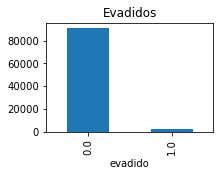

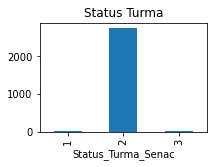

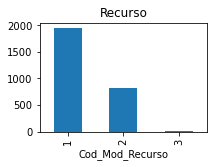

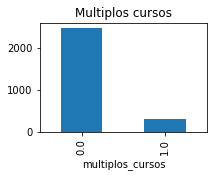

<AxesSubplot:title={'center':'Mesmo Muni'}, xlabel='mesmo_muni'>

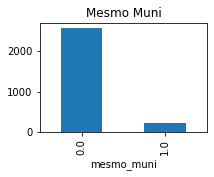

In [27]:
df.groupby("evadido")["Matricula_Apurada_Mes"].sum().plot(kind="bar", 
                                                          title="Evadidos",
                                                         figsize=(3,2))
plt.show()
df.loc[df.evadido==1].groupby("Status_Turma_Senac")["Matricula_Apurada_Mes"].\
sum().plot(kind="bar",title="Status Turma",figsize=(3,2))
plt.show()

df.loc[df.evadido==1].groupby("Cod_Mod_Recurso")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                            title="Recurso",
                                                                             figsize=(3,2))
plt.show()

df.loc[df.evadido==1].groupby("multiplos_cursos")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                            title="Multiplos cursos",
                                                                             figsize=(3,2))


plt.show()

df.loc[df.evadido==1].groupby("mesmo_muni")["Matricula_Apurada_Mes"].sum().plot(kind="bar",
                                                                           title="Mesmo Muni",
                                                                           figsize=(3,2))


In [28]:
df = df.loc[df.Status_Turma_Senac==2]

### Merge com cursos

In [29]:
df = df[["DR", 'Cod_Curso_Senac', 'Tipo_Ensino',
         'Cod_Mod_Recurso', 'Cod_Origem', 'Cod_Nacionalidade','Atestado_Baixa_Renda', 'Sexo', 'Cod_Raca', 'Cod_Escolaridade',
           'Cod_Estado_Civil',  'Deficiencia', 'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
           'CursoId', "idade_bins", "CH_bins", "CHE_bins", 'multiplos_cursos','mesmo_muni','evadido']]

df_curso = df_curso[["Id_Curso", 'Id_Eixo', 'Id_Modalidade', 'Id_TipoCurso','Regional']].drop_duplicates()
df_curso["Regional"] = df_curso["Regional"].str.strip()

df = df.merge(df_curso, left_on=["DR",  'Cod_Curso_Senac'],
             right_on=["Regional", "Id_Curso"], how="left")

df.drop(["DR", "Regional", "Id_Curso", "Cod_Curso_Senac"], axis=1, inplace=True)

33033
Tipo_Ensino                  0
Cod_Mod_Recurso              0
Cod_Origem                   1
Cod_Nacionalidade            0
Atestado_Baixa_Renda         0
Sexo                         0
Cod_Raca                  8284
Cod_Escolaridade          3131
Cod_Estado_Civil          8090
Deficiencia                  0
Trabalha_Atualmente      16951
Cod_Renda_Familiar       16987
Contrato_Aprendizagem        0
CursoId                      0
idade_bins                   0
CH_bins                      0
CHE_bins                     0
multiplos_cursos             0
mesmo_muni                   0
evadido                      0
Id_Eixo                      0
Id_Modalidade                0
Id_TipoCurso                 0
dtype: int64
---------
% evadido 0.20107165561711016


<AxesSubplot:title={'center':'Evadidos turmas concluidas'}, xlabel='evadido'>

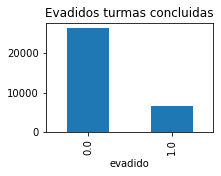

In [30]:
print(len(df))
print(df.isna().sum())
print("---------")
print("% evadido",len(df.loc[df.evadido==1])/len(df))
df.groupby("evadido")["Tipo_Ensino"].count().plot(kind="bar", 
                                                title="Evadidos turmas concluidas",
                                                figsize=(3,2))

### Merge com Uops

### Correlation

In [32]:
corr = df.corr()

<AxesSubplot:>

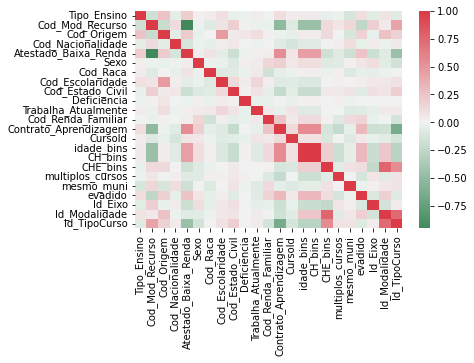

In [33]:
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            cmap=cmap, center=0)

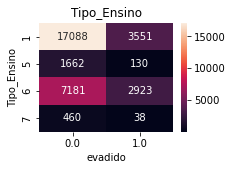

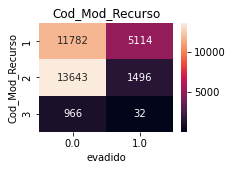

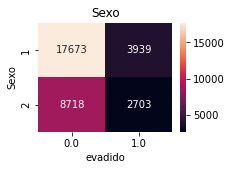

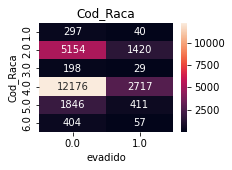

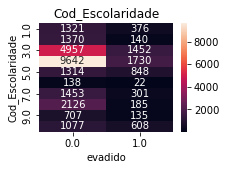

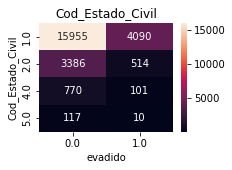

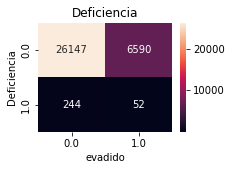

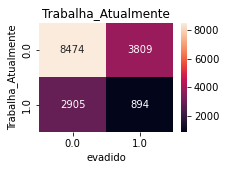

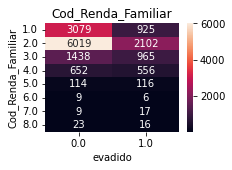

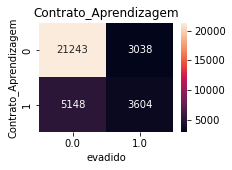

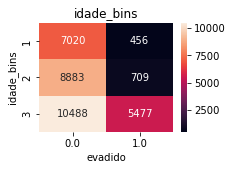

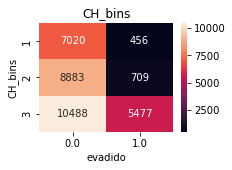

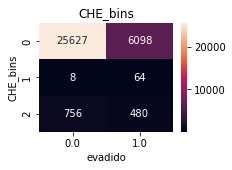

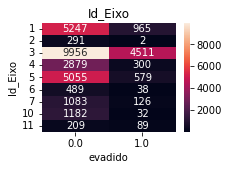

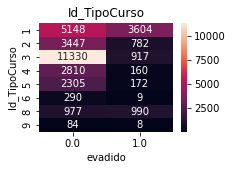

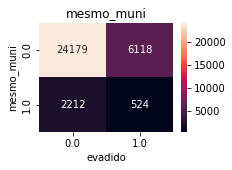

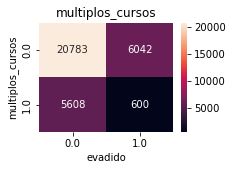

In [34]:
import seaborn as sns
for c in ['Tipo_Ensino', 'Cod_Mod_Recurso', 'Sexo', 'Cod_Raca',
         'Cod_Escolaridade', 'Cod_Estado_Civil', 'Deficiencia',
         'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
         'idade_bins', 'CH_bins', 'CHE_bins', 'Id_Eixo',
         'Id_TipoCurso', "mesmo_muni", "multiplos_cursos"]:
    fig, ax = plt.subplots(figsize=(3,2))
    sns.heatmap(pd.crosstab(df[c],df.evadido), annot=True, fmt="d", ax=ax)
    plt.title(c)
    plt.show()

## ML

In [35]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_classif, mutual_info_classif

### Feature Selection

In [36]:
df_teste = df.dropna()[['Tipo_Ensino', 'Cod_Mod_Recurso', 'Sexo', 'Cod_Raca',
         'Cod_Escolaridade', 'Cod_Estado_Civil', 'Deficiencia',
         'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
         'idade_bins', 'CH_bins', 'CHE_bins', 'Id_Eixo',
         'Id_TipoCurso', "multiplos_cursos", "mesmo_muni","evadido"]]

X = df_teste[['Tipo_Ensino', 'Cod_Mod_Recurso', 'Sexo',
         'Cod_Escolaridade', 'Cod_Estado_Civil', 'Deficiencia',
         'Trabalha_Atualmente', 'Cod_Renda_Familiar', 'Contrato_Aprendizagem',
         'idade_bins', 'CH_bins', 'CHE_bins', 'Id_Eixo',
         'Id_TipoCurso', 'multiplos_cursos', "mesmo_muni"]]

y = df_teste.evadido
print("% evadidos = ", (y[y==1].sum())/len(y))

% evadidos =  0.2698952334697842


#### Melhores variaveis com chi_square

In [37]:
f = 15
bestfeatures = SelectKBest(score_func=chi2, k=f)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score_chi']  #naming the dataframe columns

#### Melhores variaveis com f_classif

In [38]:
bestfeatures = SelectKBest(score_func=f_classif, k=f)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores_f = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_f.columns = ['Specs','Score_F']  #naming the dataframe columns
featureScores = featureScores.merge(featureScores_f, on="Specs")

#### Melhores variaveis com mutual info

In [39]:
bestfeatures = SelectKBest(score_func=mutual_info_classif, k=f)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores_m = pd.concat([dfcolumns,dfscores],axis=1)
featureScores_m.columns = ['Specs','Score_mut']  #naming the dataframe columns
featureScores = featureScores.merge(featureScores_m, on="Specs")

#### Feature importance com Tree

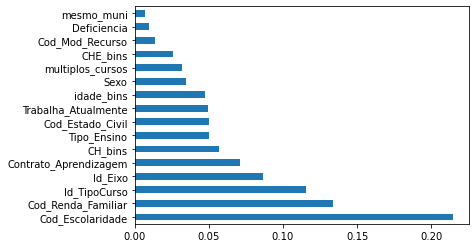

In [40]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt

model = ExtraTreesClassifier()
model.fit(X,y)
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(19).plot(kind='barh')
plt.show()

In [41]:
feat_importances.name = "Tree Class"
featureScores = featureScores.merge(feat_importances, left_on="Specs", right_index=True)

In [42]:
featureScores.sort_values("Score_chi", ascending=False)

,Specs,Score_chi,Score_F,Score_mut,Tree Class
8,Contrato_Aprendizagem,519.362473,949.255128,0.029901,0.070763
0,Tipo_Ensino,346.821291,185.678317,0.020296,0.050419
3,Cod_Escolaridade,290.643085,243.908364,0.024537,0.214914
14,multiplos_cursos,237.997054,299.674501,0.009681,0.032113
9,idade_bins,175.713474,1000.174700,0.037010,0.047657
10,CH_bins,175.713474,1000.174700,0.040028,0.056738
7,Cod_Renda_Familiar,146.608745,333.855209,0.015254,0.133681
15,mesmo_muni,66.600599,68.691225,0.006520,0.007044
11,CHE_bins,64.069976,36.867132,0.000000,0.025987
6,Trabalha_Atualmente,24.915385,33.434471,0.001083,0.049664


<AxesSubplot:>

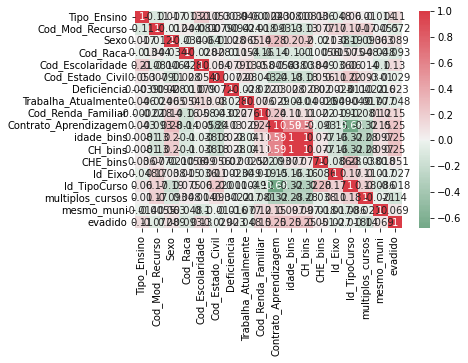

In [43]:
corr = df_teste.corr()
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
            cmap=cmap, center=0,
           annot=True)

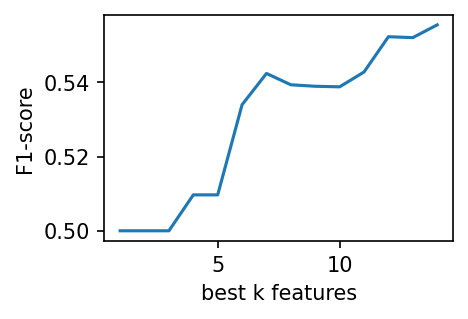

In [44]:
import sklearn.feature_selection as fs
import sklearn.datasets as datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as metrics
import matplotlib.pyplot as plt


f1_list = []
for k in range(1, 15):
    bk = fs.SelectKBest(score_func=f_classif, k=k)
    bk.fit(X, y)
    X_trans = bk.transform(X)
    train_x, test_x, train_y, test_y = train_test_split(X_trans,
                                                        y,
                                                        test_size=0.2,
                                                        random_state=42)
    lr = LogisticRegression(max_iter=10000)
    lr.fit(train_x, train_y)
    y_pred = lr.predict(test_x)
    f1 = metrics.roc_auc_score(test_y, y_pred)
    f1_list.append(f1)

fig, axe = plt.subplots(dpi = 150, figsize=(3,2))
axe.plot(range(1, 15), f1_list)
axe.set_xlabel("best k features")
axe.set_ylabel("F1-score")
plt.show()

#### Analise de variancia

In [45]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(0.2)
sel.fit(X,y)

VarianceThreshold(threshold=0.2)

In [46]:
_X = pd.DataFrame({"feature":sel.feature_names_in_,"variancia":sel.variances_}).sort_values("variancia", 
                                                                                            ascending=False)
_X

,feature,variancia
0,Tipo_Ensino,6.323881
3,Cod_Escolaridade,5.467492
12,Id_Eixo,2.876954
13,Id_TipoCurso,2.820120
7,Cod_Renda_Familiar,0.930636
9,idade_bins,0.473645
10,CH_bins,0.473645
4,Cod_Estado_Civil,0.294331
8,Contrato_Aprendizagem,0.243097
2,Sexo,0.224943


In [ ]:
selected_X = _X.loc[_X.variancia>=0.2]['feature'].values

### Comparação de modelos default

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV

# X_ = X[selected_X]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [50]:
model_pipeline = []
model_pipeline.append(LogisticRegression())
model_pipeline.append(SVC(probability=True))
model_pipeline.append(KNeighborsClassifier())
model_pipeline.append(DecisionTreeClassifier())
model_pipeline.append(RandomForestClassifier())
model_pipeline.append(GaussianNB())

In [51]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [52]:
model_list = ["Logistic Regression", "SVM", "KNN", 
              "Decision Tree", "Random Forest", "Naive Bayes"]
acc_list = []
auc_list = []
cm_list =[]
auc_rc_list= []

for model in model_pipeline:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    acc_list.append(metrics.accuracy_score(y_test, y_pred))
    fpr, tpr, _thresholds = metrics.roc_curve(y_test, y_pred)
    auc_list.append(round(metrics.auc(fpr, tpr), 2))
    cm_list.append(confusion_matrix(y_test, y_pred))
    pr, rc, _threshold = metrics.precision_recall_curve(y_test, y_prob[:,1])
    auc_rc_list.append(metrics.auc(rc, pr))

C:\Users\paula\Anaconda3\envs\evasao\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


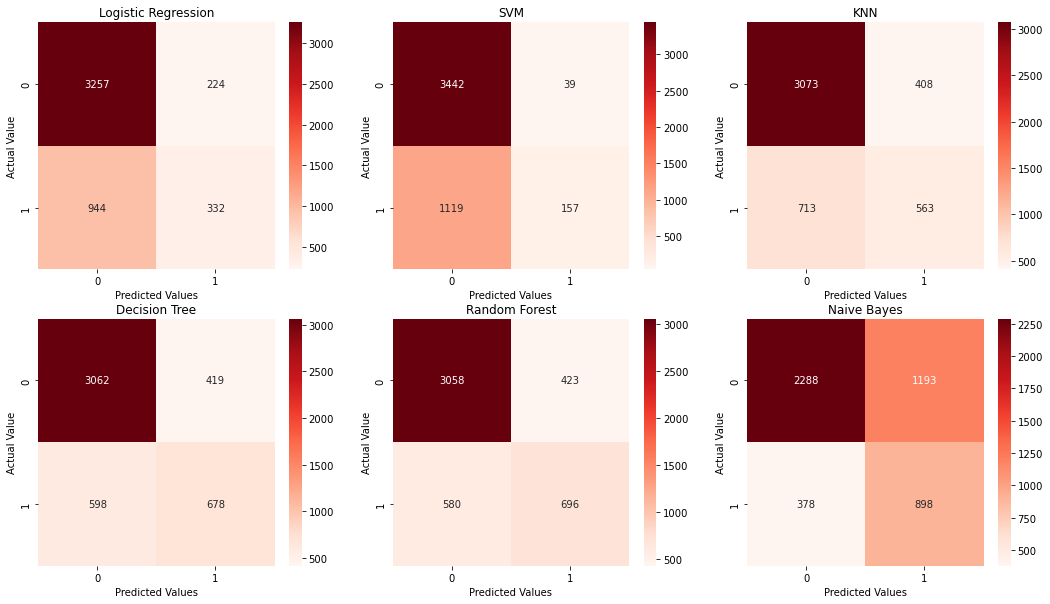

In [53]:
fig = plt.figure(figsize=(18,10))
for i in range(len(cm_list)):
    cm = cm_list[i]
    model = model_list[i]
    sub = fig.add_subplot(2,3,i+1).set_title(model)
    cm_plot = sns.heatmap(cm, annot=True, cmap="Reds", fmt="d")
    cm_plot.set_ylabel("Actual Value")
    cm_plot.set_xlabel("Predicted Values")

In [54]:
results_df = pd.DataFrame({"Model": model_list,
                          "Accuracy": acc_list,
                          "AUC": auc_list,"AUC_PR": auc_rc_list})
results_df.sort_values("Accuracy", ascending=False)

,Model,Accuracy,AUC,AUC_PR
4,Random Forest,0.789153,0.71,0.658807
3,Decision Tree,0.786210,0.71,0.655949
2,KNN,0.764347,0.66,0.574658
1,SVM,0.756569,0.56,0.563836
0,Logistic Regression,0.754467,0.60,0.510714
5,Naive Bayes,0.669750,0.68,0.465489


### Random Forest 

In [55]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

In [56]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values

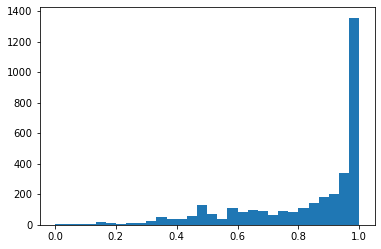

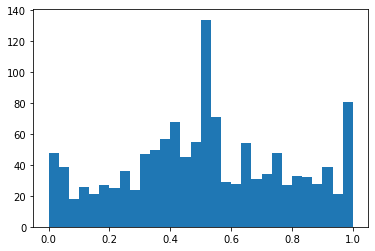

In [57]:
plt.hist(df_pred.loc[df_pred.evadido==0][0], bins=30)
plt.show()
plt.hist(df_pred.loc[df_pred.evadido==1][1], bins=30)
plt.show()

In [58]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values
df_pred.loc[df_pred[1] > 0.20, "pred"] = 1
df_pred.pred.fillna(0, inplace=True)
df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==0), "res"] = "TN"
df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==1), "res"] = "FN"
df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==0), "res"] = "FP"
df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==1), "res"] = "TP"

In [60]:
cm = pd.DataFrame(df_pred.groupby("res").count()["pred"]).reset_index()
cm

,res,pred
0,FN,179
1,FP,1150
2,TN,2331
3,TP,1097


In [61]:
recall = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FN"]["pred"].values)
precision = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FP"]["pred"].values)
f1 = (2 * precision * recall) / (precision + recall)
print(recall, precision, f1)

[0.85971787] [0.4882065] [0.62276469]


### BalancedRandomForest

In [62]:
# random forest for imbalanced classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

# define model
#model = RandomForestClassifier(n_estimators=10, class_weight='balanced_subsample')
model = BalancedRandomForestClassifier(n_estimators=50)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
#
output = cross_validate(model, X, y, cv=cv, scoring = 'roc_auc', return_estimator =True)
# summarize performance
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.844


In [63]:
for idx,estimator in enumerate(output['estimator']):
    print("Features sorted by their score for estimator {}:".format(idx))
    feature_importances = pd.DataFrame(estimator.feature_importances_,
                                       index = X.columns,
                                        columns=['importance']).sort_values('importance', ascending=False)
    print(feature_importances)

Features sorted by their score for estimator 0:
                       importance
Cod_Escolaridade         0.216276
Cod_Renda_Familiar       0.121038
Id_TipoCurso             0.109876
CH_bins                  0.090798
Id_Eixo                  0.088600
Trabalha_Atualmente      0.055602
Tipo_Ensino              0.054956
idade_bins               0.046467
Sexo                     0.045123
Contrato_Aprendizagem    0.044316
Cod_Estado_Civil         0.044219
multiplos_cursos         0.039011
Cod_Mod_Recurso          0.014399
CHE_bins                 0.013710
mesmo_muni               0.008548
Deficiencia              0.007062
Features sorted by their score for estimator 1:
                       importance
Cod_Escolaridade         0.215383
Cod_Renda_Familiar       0.121457
Id_TipoCurso             0.104227
Id_Eixo                  0.087990
CH_bins                  0.073281
idade_bins               0.069265
Tipo_Ensino              0.054399
Trabalha_Atualmente      0.053802
Contrato_Aprendizage

                       importance
Cod_Escolaridade         0.211526
Id_TipoCurso             0.125069
Cod_Renda_Familiar       0.119460
Id_Eixo                  0.088640
idade_bins               0.079017
CH_bins                  0.055483
Tipo_Ensino              0.054131
Trabalha_Atualmente      0.051277
Sexo                     0.048180
Cod_Estado_Civil         0.043661
multiplos_cursos         0.041409
Contrato_Aprendizagem    0.037985
Cod_Mod_Recurso          0.016561
CHE_bins                 0.013193
mesmo_muni               0.007579
Deficiencia              0.006829
Features sorted by their score for estimator 16:
                       importance
Cod_Escolaridade         0.215910
Cod_Renda_Familiar       0.120454
Id_TipoCurso             0.101998
Id_Eixo                  0.089936
CH_bins                  0.083021
idade_bins               0.056766
Tipo_Ensino              0.051700
Trabalha_Atualmente      0.050428
Sexo                     0.047503
Contrato_Aprendizagem    0.047443

In [64]:
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

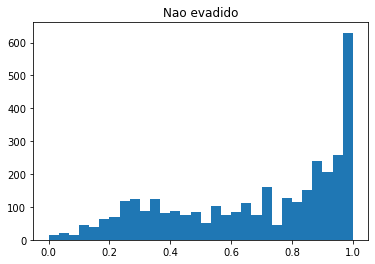

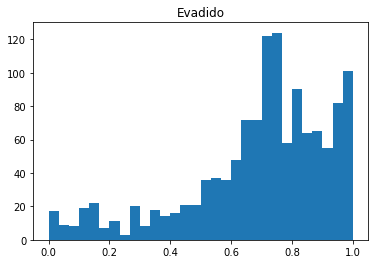

In [65]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values
plt.hist(df_pred.loc[df_pred.evadido==0][0], bins=30)
plt.title("Nao evadido")
plt.show()
plt.hist(df_pred.loc[df_pred.evadido==1][1], bins=30)
plt.title("Evadido")
plt.show()

In [66]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values
df_pred.loc[df_pred[1] > 0.49, "pred"] = 1
df_pred.pred.fillna(0, inplace=True)
df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==0), "res"] = "TN"
df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==1), "res"] = "FN"
df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==0), "res"] = "FP"
df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==1), "res"] = "TP"

In [67]:
cm = pd.DataFrame(df_pred.groupby("res").count()["pred"]).reset_index()
cm

,res,pred
0,FN,204
1,FP,1068
2,TN,2413
3,TP,1072


In [68]:
recall = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FN"]["pred"].values)
precision = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FP"]["pred"].values)
f1 = (2 * precision * recall) / (precision + recall)
print(recall, precision, f1)

[0.84012539] [0.50093458] [0.62763466]


### Logistic Regression

In [69]:
model = LogisticRegression(class_weight="balanced", solver="liblinear")
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

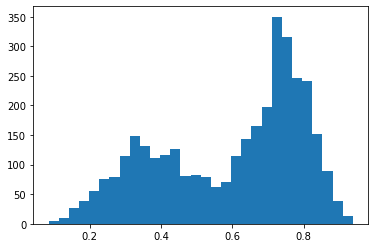

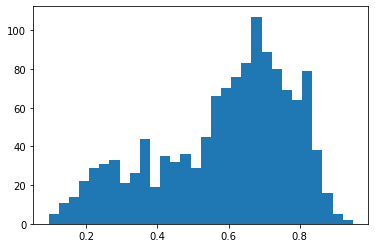

In [70]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values
plt.hist(df_pred.loc[df_pred.evadido==0][0], bins=30)
plt.show()
plt.hist(df_pred.loc[df_pred.evadido==1][1], bins=30)
plt.show()

In [71]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values
df_pred.loc[df_pred[1] > 0.4, "pred"] = 1
df_pred.pred.fillna(0, inplace=True)
df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==0), "res"] = "TN"
df_pred.loc[(df_pred.pred==0) & (df_pred.evadido==1), "res"] = "FN"
df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==0), "res"] = "FP"
df_pred.loc[(df_pred.pred==1) & (df_pred.evadido==1), "res"] = "TP"

cm = pd.DataFrame(df_pred.groupby("res").count()["pred"]).reset_index()
print(cm)
recall = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FN"]["pred"].values)
precision = cm.loc[cm["res"]=="TP"]["pred"].values / (cm.loc[cm["res"]=="TP"]["pred"].values + cm.loc[cm["res"]=="FP"]["pred"].values)
f1 = (2 * precision * recall) / (precision + recall)
print(recall, precision, f1)


  res  pred
0  FN   252
1  FP  1424
2  TN  2057
3  TP  1024
[0.80250784] [0.41830065] [0.54994629]


In [ ]:
# define hyperparameters
w = [{0:1000,1:100},{0:1000,1:10}, {0:1000,1:1.0}, 
     {0:500,1:1.0}, {0:400,1:1.0}, {0:300,1:1.0}, {0:200,1:1.0}, 
     {0:150,1:1.0}, {0:100,1:1.0}, {0:99,1:1.0}, {0:10,1:1.0}, 
     {0:0.01,1:1.0}, {0:0.01,1:10}, {0:0.01,1:100}, 
     {0:0.001,1:1.0}, {0:0.005,1:1.0}, {0:1.0,1:1.0}, 
     {0:1.0,1:0.1}, {0:10,1:0.1}, {0:100,1:0.1}, 
     {0:10,1:0.01}, {0:1.0,1:0.01}, {0:1.0,1:0.001}, {0:1.0,1:0.005}, 
     {0:1.0,1:10}, {0:1.0,1:99}, {0:1.0,1:100}, {0:1.0,1:150}, 
     {0:1.0,1:200}, {0:1.0,1:300},{0:1.0,1:400},{0:1.0,1:500}, 
     {0:1.0,1:1000}, {0:10,1:1000},{0:100,1:1000} ]
crange = np.arange(0, 20.0, 0.25)
hyperparam_grid = {"class_weight": w
                   ,"penalty": ["l1", "l2"]
                   ,"C": crange
                   ,"fit_intercept": [True, False]}

In [ ]:
lg4 = LogisticRegression(random_state=13)# define evaluation procedure
grid = GridSearchCV(lg4,hyperparam_grid,scoring="roc_auc", cv=3, n_jobs=-1, refit=True)
grid.fit(X,y)
print(f'Best score: {grid.best_score_} with param: {grid.best_params_}')

In [ ]:
GridSearchCV?

In [ ]:
lg4.fit(C=5.5)
y_pred = lg4.predict_proba(X_test)

#### Naive Bayes

In [ ]:
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict_proba(X_test)

In [ ]:
df_pred = pd.DataFrame(y_pred)
df_pred["evadido"] = y_test.values
plt.hist(df_pred.loc[df_pred.evadido==0][0], bins=15)
plt.show()
plt.hist(df_pred.loc[df_pred.evadido==1][1], bins=15)
plt.show()